***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying top-down approach. (Coarse-to-Fine)
- Changing the Secondary Capsule Dimension:
    - 8D>12D>16D (Coarse>Medium>FINE)
    - Just use Hinge Loss (MarginLoss) for each level.

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\Google_Drive\Projects\Deep Learning\HD-CapsNet\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
# directory = sysenv.log_dir('MOD_1/4_CIFAR_100/HD_CapsNet/TD_WO_C_loss')
directory = sysenv.log_dir('TD_WO_C_loss')


FOLDER CREATED =  ../../logs/TD_WO_C_loss


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
from src.models import *

In [7]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [9]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 8)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'/tb_logs')
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    
                    verbose=1)
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5423 - prediction_coarse_accuracy: 0.4661 - prediction_medium_accuracy: 0.1829 - prediction_fine_accuracy: 0.0092
  • Coarse Accuracy = 46.61% | Val_Accuracy = 50.45% | LossWeight = 0.36 
  • Medium Accuracy = 18.29% | Val_Accuracy = 26.71% | LossWeight = 0.49 
  • Fine   Accuracy = 0.92% | Val_Accuracy = 0.57% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00570, saving model to ../../logs/TD_WO_C_loss\weights-01.h5
781/781 [==============================] - 42s 42ms/step - loss: 0.5423 - prediction_coarse_accuracy: 0.4661 - prediction_medium_accuracy: 0.1829 - prediction_fine_accuracy: 0.0092 - val_loss: 0.4660 - val_prediction_coarse_accuracy: 0.5045 - val_prediction_medium_accuracy: 0.2671 - val_prediction_fine_accuracy: 0.0057 - lr: 0.0010
Epoch 2/100
780/781 [============================>.] - ETA: 0s - loss: 0.3936 - prediction_coarse_accuracy: 0.5879 - prediction_medium_

781/781 [==============================] - 39s 50ms/step - loss: 0.2333 - prediction_coarse_accuracy: 0.8335 - prediction_medium_accuracy: 0.7361 - prediction_fine_accuracy: 0.0846 - val_loss: 0.2132 - val_prediction_coarse_accuracy: 0.8122 - val_prediction_medium_accuracy: 0.7021 - val_prediction_fine_accuracy: 0.1159 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.2209 - prediction_coarse_accuracy: 0.8458 - prediction_medium_accuracy: 0.7548 - prediction_fine_accuracy: 0.1397
  • Coarse Accuracy = 84.58% | Val_Accuracy = 80.58% | LossWeight = 0.27 
  • Medium Accuracy = 75.48% | Val_Accuracy = 69.18% | LossWeight = 0.38 
  • Fine   Accuracy = 13.97% | Val_Accuracy = 15.85% | LossWeight = 0.35 

Epoch 10: val_prediction_fine_accuracy improved from 0.11590 to 0.15850, saving model to ../../logs/TD_WO_C_loss\weights-10.h5
781/781 [==============================] - 40s 51ms/step - loss: 0.2209 - prediction_coarse_accuracy: 0.8458 - prediction_medium

781/781 [==============================] - 39s 50ms/step - loss: 0.1485 - prediction_coarse_accuracy: 0.9201 - prediction_medium_accuracy: 0.8801 - prediction_fine_accuracy: 0.3174 - val_loss: 0.1709 - val_prediction_coarse_accuracy: 0.8311 - val_prediction_medium_accuracy: 0.7339 - val_prediction_fine_accuracy: 0.2934 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1449 - prediction_coarse_accuracy: 0.9216 - prediction_medium_accuracy: 0.8875 - prediction_fine_accuracy: 0.3339
  • Coarse Accuracy = 92.16% | Val_Accuracy = 83.99% | LossWeight = 0.23 
  • Medium Accuracy = 88.75% | Val_Accuracy = 73.81% | LossWeight = 0.30 
  • Fine   Accuracy = 33.39% | Val_Accuracy = 31.04% | LossWeight = 0.46 

Epoch 19: val_prediction_fine_accuracy improved from 0.29340 to 0.31040, saving model to ../../logs/TD_WO_C_loss\weights-19.h5
781/781 [==============================] - 39s 50ms/step - loss: 0.1449 - prediction_coarse_accuracy: 0.9216 - prediction_me

781/781 [==============================] - 38s 48ms/step - loss: 0.1246 - prediction_coarse_accuracy: 0.9429 - prediction_medium_accuracy: 0.9228 - prediction_fine_accuracy: 0.4609 - val_loss: 0.1552 - val_prediction_coarse_accuracy: 0.8435 - val_prediction_medium_accuracy: 0.7539 - val_prediction_fine_accuracy: 0.4095 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1235 - prediction_coarse_accuracy: 0.9423 - prediction_medium_accuracy: 0.9237 - prediction_fine_accuracy: 0.4720
  • Coarse Accuracy = 94.23% | Val_Accuracy = 84.81% | LossWeight = 0.23 
  • Medium Accuracy = 92.37% | Val_Accuracy = 75.92% | LossWeight = 0.28 
  • Fine   Accuracy = 47.20% | Val_Accuracy = 42.03% | LossWeight = 0.49 

Epoch 28: val_prediction_fine_accuracy improved from 0.40950 to 0.42030, saving model to ../../logs/TD_WO_C_loss\weights-28.h5
781/781 [==============================] - 39s 50ms/step - loss: 0.1235 - prediction_coarse_accuracy: 0.9423 - prediction_me

Epoch 37/100
780/781 [============================>.] - ETA: 0s - loss: 0.1136 - prediction_coarse_accuracy: 0.9517 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.5674
  • Coarse Accuracy = 95.17% | Val_Accuracy = 85.43% | LossWeight = 0.24 
  • Medium Accuracy = 93.76% | Val_Accuracy = 76.52% | LossWeight = 0.27 
  • Fine   Accuracy = 56.76% | Val_Accuracy = 47.93% | LossWeight = 0.49 

Epoch 37: val_prediction_fine_accuracy improved from 0.47230 to 0.47930, saving model to ../../logs/TD_WO_C_loss\weights-37.h5
781/781 [==============================] - 38s 49ms/step - loss: 0.1136 - prediction_coarse_accuracy: 0.9517 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.5676 - val_loss: 0.1456 - val_prediction_coarse_accuracy: 0.8543 - val_prediction_medium_accuracy: 0.7652 - val_prediction_fine_accuracy: 0.4793 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.1128 - prediction_coarse_accuracy: 0.9513 - predic

781/781 [==============================] - ETA: 0s - loss: 0.1094 - prediction_coarse_accuracy: 0.9534 - prediction_medium_accuracy: 0.9398 - prediction_fine_accuracy: 0.6181
  • Coarse Accuracy = 95.34% | Val_Accuracy = 86.02% | LossWeight = 0.25 
  • Medium Accuracy = 93.98% | Val_Accuracy = 77.16% | LossWeight = 0.29 
  • Fine   Accuracy = 61.81% | Val_Accuracy = 51.45% | LossWeight = 0.47 

Epoch 46: val_prediction_fine_accuracy improved from 0.51000 to 0.51450, saving model to ../../logs/TD_WO_C_loss\weights-46.h5
781/781 [==============================] - 39s 49ms/step - loss: 0.1094 - prediction_coarse_accuracy: 0.9534 - prediction_medium_accuracy: 0.9398 - prediction_fine_accuracy: 0.6181 - val_loss: 0.1428 - val_prediction_coarse_accuracy: 0.8602 - val_prediction_medium_accuracy: 0.7716 - val_prediction_fine_accuracy: 0.5145 - lr: 1.5778e-04
Epoch 47/100
780/781 [============================>.] - ETA: 0s - loss: 0.1086 - prediction_coarse_accuracy: 0.9549 - prediction_medium_a

781/781 [==============================] - ETA: 0s - loss: 0.1066 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9448 - prediction_fine_accuracy: 0.6489
  • Coarse Accuracy = 95.55% | Val_Accuracy = 85.96% | LossWeight = 0.25 
  • Medium Accuracy = 94.48% | Val_Accuracy = 77.45% | LossWeight = 0.28 
  • Fine   Accuracy = 64.89% | Val_Accuracy = 53.23% | LossWeight = 0.47 

Epoch 55: val_prediction_fine_accuracy improved from 0.53050 to 0.53230, saving model to ../../logs/TD_WO_C_loss\weights-55.h5
781/781 [==============================] - 38s 49ms/step - loss: 0.1066 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9448 - prediction_fine_accuracy: 0.6489 - val_loss: 0.1411 - val_prediction_coarse_accuracy: 0.8596 - val_prediction_medium_accuracy: 0.7745 - val_prediction_fine_accuracy: 0.5323 - lr: 9.9440e-05
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.1060 - prediction_coarse_accuracy: 0.9565 - prediction_medium_a

781/781 [==============================] - 40s 52ms/step - loss: 0.1044 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9475 - prediction_fine_accuracy: 0.6780 - val_loss: 0.1394 - val_prediction_coarse_accuracy: 0.8619 - val_prediction_medium_accuracy: 0.7754 - val_prediction_fine_accuracy: 0.5409 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.1038 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9467 - prediction_fine_accuracy: 0.6763
  • Coarse Accuracy = 95.82% | Val_Accuracy = 86.16% | LossWeight = 0.25 
  • Medium Accuracy = 94.67% | Val_Accuracy = 77.54% | LossWeight = 0.29 
  • Fine   Accuracy = 67.63% | Val_Accuracy = 53.76% | LossWeight = 0.46 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.54090
781/781 [==============================] - 39s 50ms/step - loss: 0.1038 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9467 - prediction_fine_accuracy: 0.6763 - 

Epoch 74/100
780/781 [============================>.] - ETA: 0s - loss: 0.1040 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9463 - prediction_fine_accuracy: 0.6946
  • Coarse Accuracy = 95.79% | Val_Accuracy = 86.29% | LossWeight = 0.26 
  • Medium Accuracy = 94.63% | Val_Accuracy = 77.78% | LossWeight = 0.30 
  • Fine   Accuracy = 69.45% | Val_Accuracy = 54.58% | LossWeight = 0.44 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.54600
781/781 [==============================] - 39s 50ms/step - loss: 0.1040 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9463 - prediction_fine_accuracy: 0.6945 - val_loss: 0.1389 - val_prediction_coarse_accuracy: 0.8629 - val_prediction_medium_accuracy: 0.7778 - val_prediction_fine_accuracy: 0.5458 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.1034 - prediction_coarse_accuracy: 0.9585 - prediction_medium_accuracy: 0.9489 - prediction_fine_accuracy: 0.

781/781 [==============================] - 37s 47ms/step - loss: 0.1042 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9470 - prediction_fine_accuracy: 0.6980 - val_loss: 0.1390 - val_prediction_coarse_accuracy: 0.8626 - val_prediction_medium_accuracy: 0.7785 - val_prediction_fine_accuracy: 0.5514 - lr: 2.3650e-05
Epoch 84/100
780/781 [============================>.] - ETA: 0s - loss: 0.1027 - prediction_coarse_accuracy: 0.9599 - prediction_medium_accuracy: 0.9489 - prediction_fine_accuracy: 0.6983
  • Coarse Accuracy = 95.99% | Val_Accuracy = 86.44% | LossWeight = 0.26 
  • Medium Accuracy = 94.88% | Val_Accuracy = 77.85% | LossWeight = 0.29 
  • Fine   Accuracy = 69.83% | Val_Accuracy = 55.09% | LossWeight = 0.45 

Epoch 84: val_prediction_fine_accuracy did not improve from 0.55140
781/781 [==============================] - 36s 47ms/step - loss: 0.1027 - prediction_coarse_accuracy: 0.9599 - prediction_medium_accuracy: 0.9488 - prediction_fine_accuracy: 0.6983 - 

780/781 [============================>.] - ETA: 0s - loss: 0.1035 - prediction_coarse_accuracy: 0.9583 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.7023
  • Coarse Accuracy = 95.83% | Val_Accuracy = 86.39% | LossWeight = 0.26 
  • Medium Accuracy = 94.77% | Val_Accuracy = 77.85% | LossWeight = 0.30 
  • Fine   Accuracy = 70.23% | Val_Accuracy = 55.05% | LossWeight = 0.44 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.55270
781/781 [==============================] - 40s 51ms/step - loss: 0.1035 - prediction_coarse_accuracy: 0.9583 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.7023 - val_loss: 0.1382 - val_prediction_coarse_accuracy: 0.8639 - val_prediction_medium_accuracy: 0.7785 - val_prediction_fine_accuracy: 0.5505 - lr: 1.4160e-05
Epoch 94/100
781/781 [==============================] - ETA: 0s - loss: 0.1032 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9471 - prediction_fine_accuracy: 0.7013
  • Coar

In [17]:
history_dict = history.history

(0.0, 1.0)

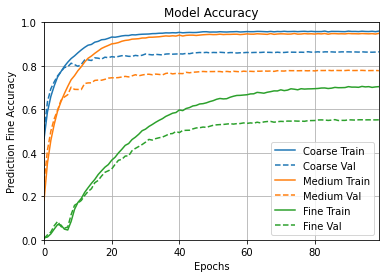

In [18]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

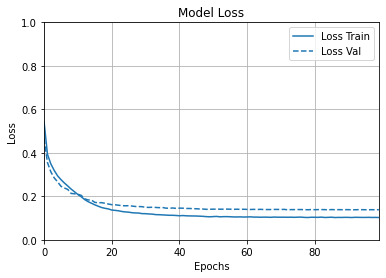

In [19]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : MarginLoss(),
                          'prediction_medium' : MarginLoss(),
                          'prediction_coarse' : MarginLoss()},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 20ms/step - loss: 0.2402 - prediction_coarse_loss: 0.1037 - prediction_medium_loss: 0.1675 - prediction_fine_loss: 0.3679 - prediction_coarse_accuracy: 0.8645 - prediction_medium_accuracy: 0.7778 - prediction_fine_accuracy: 0.5518
1. loss ==> 0.24020233750343323
2. prediction_coarse_loss ==> 0.10367186367511749
3. prediction_medium_loss ==> 0.16745759546756744
4. prediction_fine_loss ==> 0.3679090142250061
5. prediction_coarse_accuracy ==> 0.8644999861717224
6. prediction_medium_accuracy ==> 0.7778000235557556
7. prediction_fine_accuracy ==> 0.551800012588501
313/313 [==============================] - 4s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

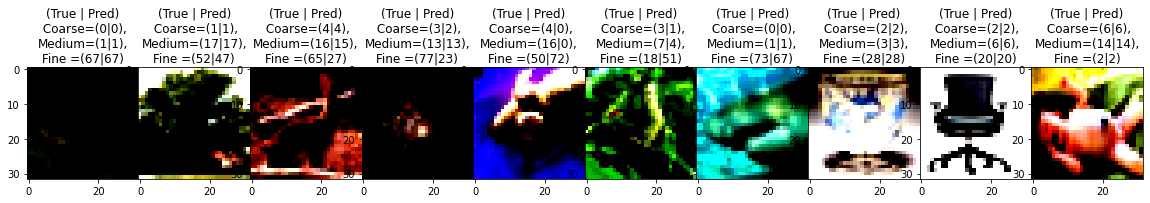

In [21]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 715   13   24   30  181   12   12   13]
 [   9 1381   29   24   36   17    0    4]
 [   7   32 1365   19   18   12   15   32]
 [  12   34   31  799  109    1    4   10]
 [  94   26   51  106 2176   12   12   23]
 [   6   29   23    4   32  875    3   28]
 [   3   11   12    9   29    1  433    2]
 [   9    4   33   11   26   16    0  901]]

  • MEDIUM LEVEL 
[[331  28   0   2   2   7   4   5  14   1   3   6  17  10   3  35  23   1
    5   3]
 [ 31 354   7   4   4   4   2   7   2   3   6   5   6   7   9  33  11   2
    1   2]
 [  0   4 452   3  15   3   1   9   1   1   1   0   0   2   0   5   1   1
    1   0]
 [  0   0   5 405  16  41   7   1   1   0   1   1   0   7   4   3   0   0
    4   4]
 [  2   3  22  11 426  10   0   2   2   1   1   4   2   5   0   3   4   1
    0   1]
 [  0   3   2  37   7 380  21   3   1   3   3   2   2   5  10   3   2   4
    4   8]
 [  3   2   3  15   1  19 424   2   0   3   1   1   0   4   4   3   1   1
    9   4]


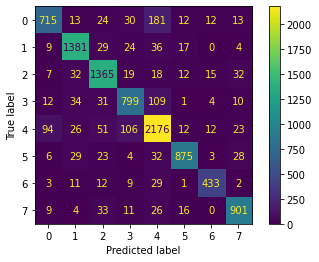

              precision    recall  f1-score   support

           0    0.83626   0.71500   0.77089      1000
           1    0.90261   0.92067   0.91155      1500
           2    0.87054   0.91000   0.88983      1500
           3    0.79741   0.79900   0.79820      1000
           4    0.83468   0.87040   0.85216      2500
           5    0.92495   0.87500   0.89928      1000
           6    0.90397   0.86600   0.88458       500
           7    0.88944   0.90100   0.89518      1000

    accuracy                        0.86450     10000
   macro avg    0.86998   0.85713   0.86271     10000
weighted avg    0.86464   0.86450   0.86383     10000


  • MEDIUM LEVEL 


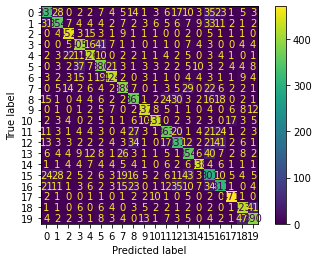

              precision    recall  f1-score   support

           0    0.70878   0.66200   0.68459       500
           1    0.77293   0.70800   0.73904       500
           2    0.85932   0.90400   0.88109       500
           3    0.77885   0.81000   0.79412       500
           4    0.81923   0.85200   0.83529       500
           5    0.72519   0.76000   0.74219       500
           6    0.86004   0.84800   0.85398       500
           7    0.78112   0.77800   0.77956       500
           8    0.71262   0.73400   0.72315       500
           9    0.89002   0.87400   0.88194       500
          10    0.90546   0.86200   0.88320       500
          11    0.77234   0.72600   0.74845       500
          12    0.70576   0.66200   0.68318       500
          13    0.68872   0.70800   0.69822       500
          14    0.88664   0.87600   0.88129       500
          15    0.53846   0.60200   0.56846       500
          16    0.66595   0.62200   0.64323       500
          17    0.90577   0

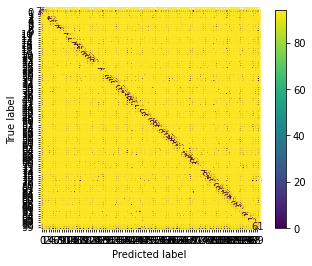

              precision    recall  f1-score   support

           0    0.90361   0.75000   0.81967       100
           1    0.91304   0.63000   0.74556       100
           2    0.29927   0.41000   0.34599       100
           3    0.32787   0.40000   0.36036       100
           4    0.37302   0.47000   0.41593       100
           5    0.51376   0.56000   0.53589       100
           6    0.69149   0.65000   0.67010       100
           7    0.65574   0.40000   0.49689       100
           8    0.83908   0.73000   0.78075       100
           9    0.87209   0.75000   0.80645       100
          10    0.00000   0.00000   0.00000       100
          11    0.35897   0.28000   0.31461       100
          12    0.55118   0.70000   0.61674       100
          13    0.52703   0.39000   0.44828       100
          14    0.35374   0.52000   0.42105       100
          15    0.48148   0.39000   0.43094       100
          16    0.45679   0.74000   0.56489       100
          17    0.88889   0

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [23]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7311816666666666 
Hierarchical Recall = 0.7426 
Hierarchical F1-Score = 0.7356809523809524 
Consistency =  0.9264 
Exact Match =  0.5393
